In [1]:
%run -i model.ipynb

100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


## Recovering conditional density with RealNVP


$p(y, \mu) = p(y | \mu) p(\mu)$

$p(\mu) = \delta(\mu - \mu_0)$

In [2]:
device = torch.device('cuda:0')

In [3]:
from torch import nn
from itertools import chain

class RealNVP(nn.Module):
    def __init__(self, nets, nett, masks, prior):
        super(RealNVP, self).__init__()
        self.prior = prior
        self.masks = nn.Parameter(masks, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        x = z
        for i in reversed(range(len(self.masks))):
            x = self.masks[i] * x + \
              (1 - self.masks[i]) * ((1 - self.masks[i]) * x - self.t[i](self.masks[i] * x)) * (-self.s[i](self.masks[i] * x)).exp()
        return x

    def f(self, x):
        log_det_J = []
        for i in range(len(self.masks)):
            x = self.masks[i] * x + \
               (1 - self.masks[i]) * (x * (self.s[i](self.masks[i] * x)).exp() + self.t[i](self.masks[i] * x))
            log_det_J.append(((1 - self.masks[i]) * self.s[i](self.masks[i] * x)).sum(dim=1))

        return x, sum(log_det_J)
    
    def log_prob(self, x):
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        z = self.prior.sample(batchSize)
        x = self.g(z)
        return x

In [4]:
NUM_NEURONS = 16
NUM_LAYERS = 2
NUM_COUPLIN = 5

In [5]:
nets = lambda: nn.Sequential(*
                             [nn.Linear(dimX, NUM_NEURONS), nn.Tanh()] + 
                             list(chain.from_iterable([[nn.Linear(NUM_NEURONS, NUM_NEURONS), nn.Tanh()] for _ in range(NUM_LAYERS)])) + 
                             [nn.Linear(NUM_NEURONS, dimX)]
                            )
nett = lambda: nn.Sequential(*
                             [nn.Linear(dimX, NUM_NEURONS), nn.Tanh()] + 
                             list(chain.from_iterable([[nn.Linear(NUM_NEURONS, NUM_NEURONS), nn.Tanh()] for _ in range(NUM_LAYERS)])) + 
                             [nn.Linear(NUM_NEURONS, dimX)]
                            )

In [6]:
dimX = 2

masks = []
for i in range(NUM_COUPLIN):
    masks.append(torch.fmod(torch.arange(2, dtype=torch.float32) + i, 2))
masks = torch.stack(masks, dim=0).to(device)

In [7]:
class CondPrior:
    def __init__(self, mu_dist):
        self.mu_dist = mu_dist
        self.independent = dist.Normal(loc=torch.tensor(0.).to(device), scale=torch.tensor(1.).to(device))
        
    def log_prob(self, x):
        mu = pyro.sample('mu', self.mu_dist)
        mu_dist_approx = dist.Normal(loc=mu.to(device), scale=torch.tensor(0.01).to(device))
        log_prob = self.independent.log_prob(x[:, 0]) + mu_dist_approx.log_prob(x[:, 1])
        return log_prob
    
    def sample(self, batchSize):
        z = torch.stack([self.independent.sample([batchSize]), pyro.sample('mu', self.mu_dist)]).t()
        return z

In [8]:
prior = CondPrior(mu_dist)

In [9]:
flow = RealNVP(nets, nett, masks, prior).to(device)

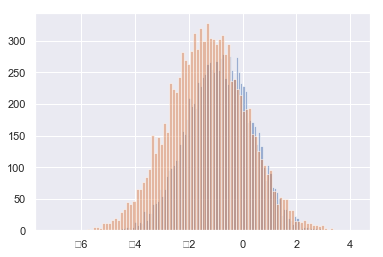

In [10]:
with pyro.condition(data={"mu": mu_dist.v.repeat(10000).detach().to(device)}):
    samples = y_sample()
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

with pyro.condition(data={"mu": mu_dist.v.repeat(10000).detach().to(device)}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

In [11]:
def reg_foo(parameters): 
    return sum([param.norm() for param in parameters])

In [12]:
mus = torch.tensor(1.).repeat(10000).to(device)
with pyro.condition(data={"mu": mus}):
    samples = y_sample()
    data = torch.stack([samples.to(device), 
                        mus]).detach().t()

In [13]:
from sklearn import datasets
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(flow.parameters()) # list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)# choose an optimizer, use module torch.optim

for t in tqdm(range(1000)):
    # on each iteration different \mu
    # new_mu = ((torch.rand(1) - 0.5) * 100)[0].to(device)
    # flow.prior.loc=torch.stack([torch.tensor(0.), new_mu]).to(device)
    # conditioned_y_sample = poutine.condition(y_sample, data={"mu": new_mu})
    with pyro.condition(data={"mu": torch.tensor(1.)}):
        flow_loss = -flow.log_prob(data).mean()
    
    loss = flow_loss + 1e-6 * reg_foo(trainable_parametrs) # compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 20 == 0:
        print('iter %s:' % t, 'loss = %.3f' % flow_loss)

iter 0: loss = 1201.188
iter 20: loss = 518.824
iter 40: loss = 157.586
iter 60: loss = 42.728
iter 80: loss = 20.581
iter 100: loss = 14.007
iter 120: loss = 11.198
iter 140: loss = 9.763
iter 160: loss = 8.694
iter 180: loss = 7.745
iter 200: loss = 6.859
iter 220: loss = 6.029
iter 240: loss = 5.255
iter 260: loss = 4.536
iter 280: loss = 3.871
iter 300: loss = 3.259
iter 320: loss = 2.698
iter 340: loss = 2.184
iter 360: loss = 1.716
iter 380: loss = 1.291
iter 400: loss = 0.906
iter 420: loss = 0.558
iter 440: loss = 0.244
iter 460: loss = -0.038
iter 480: loss = -0.290
iter 500: loss = -0.516
iter 520: loss = -0.717
iter 540: loss = -0.896
iter 560: loss = -1.054
iter 580: loss = -1.194
iter 600: loss = -1.317
iter 620: loss = -1.426
iter 640: loss = -1.521
iter 660: loss = -1.604
iter 680: loss = -1.676
iter 700: loss = -1.738
iter 720: loss = -1.792
iter 740: loss = -1.839
iter 760: loss = -1.879
iter 780: loss = -1.913
iter 800: loss = -1.943
iter 820: loss = -1.968
iter 840: 

## Compare distrs

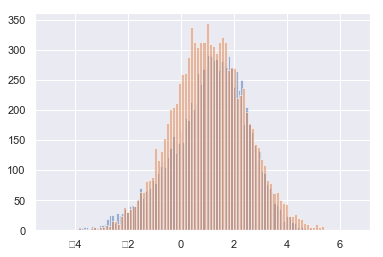

In [14]:
mus = torch.tensor(1.).repeat(10000).to(device)

with pyro.condition(data={"mu": mus}):
    samples = y_sample()
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

with pyro.condition(data={"mu": mus}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

## Conditioned

In [15]:
mu_range=(-5, 5)

In [16]:
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(100000)) + mu_range[1]).to(device)
with pyro.condition(data={"mu": mus}):
    samples = y_sample().detach().to(device)

In [17]:
data = torch.stack([samples.to(device), mus]).detach().t()

In [18]:
from sklearn import datasets
from tqdm import tqdm_notebook as tqdm

trainable_parametrs = list(flow.parameters()) # list of all trainable parameters in a flow
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-4)# choose an optimizer, use module torch.optim


for t in tqdm(range(5000)):
    # on each iteration different \mu
    with pyro.condition(data={"mu": mus}):
        flow_loss = -flow.log_prob(data).mean()
    
    loss = flow_loss + 1e-4 * reg_foo(trainable_parametrs) # compute the maximum-likelihood loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 200 == 0:
        print('iter %s:' % t, 'loss = %.3f' % flow_loss)

iter 0: loss = 1628.967
iter 200: loss = 2.147
iter 400: loss = -0.171
iter 600: loss = -1.189
iter 800: loss = -1.614
iter 1000: loss = -1.794
iter 1200: loss = -1.875
iter 1400: loss = -1.916
iter 1600: loss = -1.941
iter 1800: loss = -1.959
iter 2000: loss = -1.974
iter 2200: loss = -1.986
iter 2400: loss = -1.996
iter 2600: loss = -2.005
iter 2800: loss = -2.013
iter 3000: loss = -2.019
iter 3200: loss = -2.024
iter 3400: loss = -2.029
iter 3600: loss = -2.033
iter 3800: loss = -2.037
iter 4000: loss = -2.040
iter 4200: loss = -2.042
iter 4400: loss = -2.044
iter 4600: loss = -2.046
iter 4800: loss = -2.047



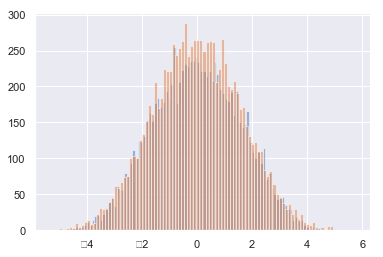

In [19]:
mus = ((mu_range[0] - mu_range[1]) * (torch.rand(10000)) + mu_range[1]).to(device)

with pyro.condition(data={"mu": mus}):
    samples = y_sample()
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

with pyro.condition(data={"mu": mus}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), bins=100, alpha=0.5);

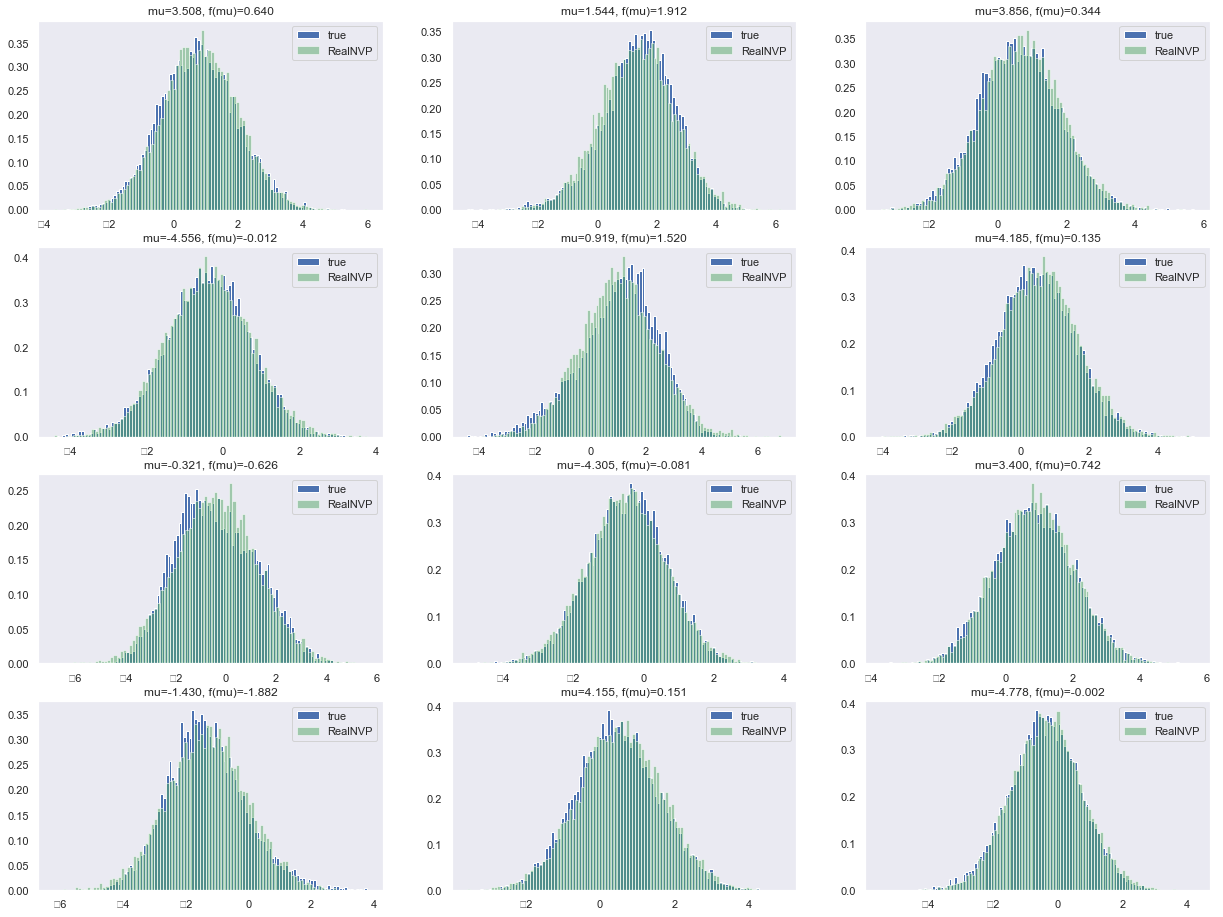

In [20]:
plt.figure(figsize=(21, 16))
for i in range(4):
    for j in range(3):
        plt.subplot(4,3, i*3 + j + 1)
        mus = torch.stack(10000 * [-10 * torch.rand(1) + 5]).view(-1).to(device)

       
        with pyro.condition(data={"mu": mus}):
            samples = y_sample().detach().to(device)  
        plt.hist(samples.detach().cpu().numpy(), bins=100, density=True, label='true');
        
        with pyro.condition(data={"mu": mus}):
            samples = flow.sample(10000)[:, 0]
        plt.hist(samples.detach().cpu().numpy(), 
                 bins=100, color='g', density=True, alpha=0.5, label='RealNVP');
        plt.grid()
        plt.legend()
        plt.title("mu={:.3f}, f(mu)={:.3f}".format(mus[0].item(), f(mus[0]).item()))

Text(0.5, 1.0, 'mu=15.000, f(mu)=1.650')

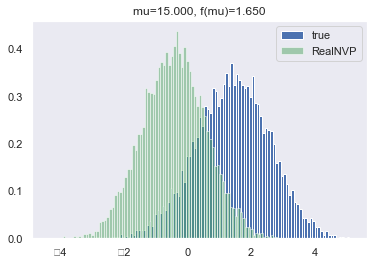

In [21]:
mus = torch.full(size=(10000, ), fill_value=15.).to(device)

with pyro.condition(data={"mu": mus}):
    samples = y_sample().detach().to(device)  
plt.hist(samples.detach().cpu().numpy(), bins=100, density=True, label='true');

with pyro.condition(data={"mu": mus}):
    samples = flow.sample(10000)[:, 0]
plt.hist(samples.detach().cpu().numpy(), 
         bins=100, color='g', density=True, alpha=0.5, label='RealNVP');
plt.grid()
plt.legend()
plt.title("mu={:.3f}, f(mu)={:.3f}".format(mus[0].item(), f(mus[0]).item()))

In [22]:
mus = torch.tensor(0.).repeat(1000).to(device)
mus.requires_grad = True

In [23]:
%%time
n_iter = 10000
lr = 1e-1

losses = []
m_vals = []
for _iter in tqdm(range(n_iter)):
    with pyro.condition(data={"mu": mus}):
        data = flow.sample(1000)[:, 0]

    loss = R(data)
    losses.append(loss.item())
    # if not mus.grad is None: mus.grad.zero_()
        
    loss.backward()
    with torch.no_grad():
        mus.data -= lr * mus.grad.mean()
        mus.grad.zero_()
    
    m_vals.append(mus[0].item())
    
    if _iter % 500 == 0:
        print(losses[-1], m_vals[-1])

27.955068588256836 -0.0013073182199150324
20.693771362304688 -0.6058265566825867
16.757062911987305 -1.0225855112075806
15.79826831817627 -1.2855089902877808
15.139264106750488 -1.456059455871582
14.622681617736816 -1.5703362226486206
15.04151439666748 -1.6492316722869873
15.033090591430664 -1.7050492763519287
14.434416770935059 -1.745008111000061
14.59403133392334 -1.773949146270752
14.198493003845215 -1.7950552701950073
14.348315238952637 -1.8107775449752808
14.602189064025879 -1.8224115371704102
14.89008903503418 -1.830881118774414
14.491979598999023 -1.8372806310653687
14.842143058776855 -1.8419727087020874
14.457291603088379 -1.8455772399902344
14.748198509216309 -1.8482491970062256
14.66310977935791 -1.8501954078674316
14.523451805114746 -1.8516881465911865

CPU times: user 2min 3s, sys: 4.85 s, total: 2min 7s
Wall time: 2min 6s


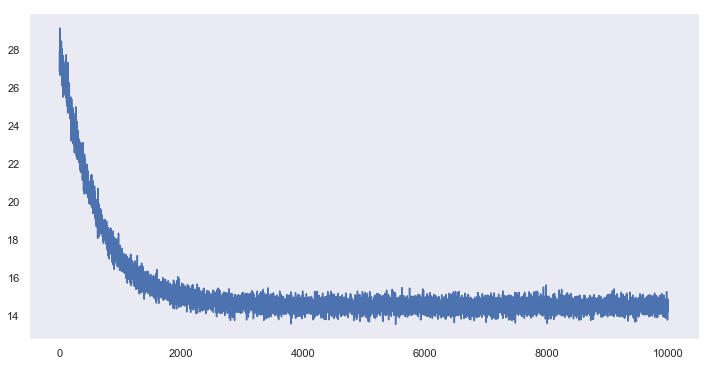

In [24]:
plt.figure(figsize=(12,6))
plt.plot(losses);
plt.grid()

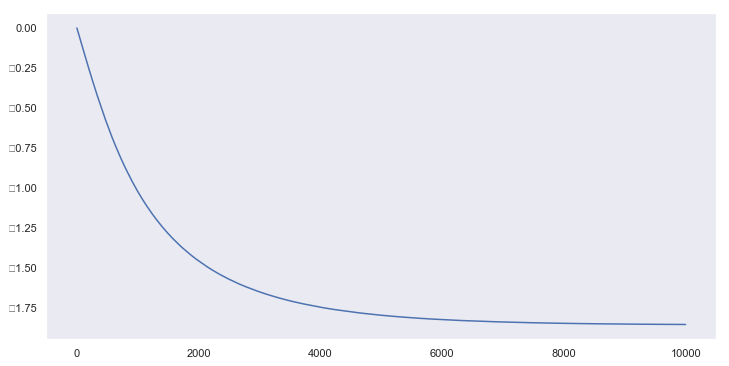

In [25]:
plt.figure(figsize=(12,6))
plt.plot(m_vals);
plt.grid()

In [27]:
m_vals[-1]

-1.8527159690856934